# Kim 2014

## Data Processing

In [1]:
import os
import random
import numpy as np
import _pickle as pickle

In [15]:
class GloveEmbeddings:
    def __init__(self):
        self.word2id = {}
        self.vectors = []
        self.words = []
        self.dim = None
        
    def load_glove(self, filename):
        id = 0
        with open(filename) as file:
            for line_ in file:
                line = line_.split()
                word = line[0]
                self.words.append(word)
                self.word2id[word] , id = id, id + 1
                vect = np.array(line[1:]).astype(np.float)
                self.vectors.append(vect)
        self.vectors = np.array(self.vectors)
        self.dim = self.vectors.shape[-1]
        self.add_to_vocab('<unk>')
    
    def add_to_vocab(self, word):
        word = word.lower()
        self.words.append(word)
        self.word2id[word] = len(self.words) - 1
        self.vectors = np.append(self.vectors, np.random.random(self.dim))
        
    def convert_to_indices(self, lines):
        indices = []
        for line in lines:
            indices.append([])
            for word in line:
                if word in self.word2id:
                    id = self.word2id[word]
                else:
                    id = self.word2id['<unk>']
                indices[-1].append(id)
        return indices

In [16]:
glove = GloveEmbeddings()
glove.load_glove('~/meta/glove/glove.6B.100d.txt')

In [17]:
def convert_to_indices(file, glove):
    with open(file, 'rb') as f:
        data = f.readlines()
    data = [str(line).split(' ') for line in data]
    return glove.convert_to_indices(data)

In [18]:
pos_data = convert_to_indices('data/rt-polaritydata/rt-polarity.pos', glove)
neg_data = convert_to_indices('data/rt-polaritydata/rt-polarity.neg', glove)

## Neural Model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

In [3]:
torch.cuda.set_device(0)

In [186]:
class KimCNN(nn.Module):
    def __init__(self, #mode='singlechannel',
                 embedding_weights=None, embedding_dim=(400001, 100), 
                 kernels=[3,4,5], out_channels=50):
        super().__init__()
        
        self.embeddings = nn.Embedding(*embedding_dim)
        if embedding_weights is not None: self.embeddings.load_state_dict({'weight': embedding_weights})
        
        self.convolutions = nn.ModuleList([nn.Conv2d(in_channels=1, 
                                                     out_channels=out_channels, 
                                                     kernel_size=(k, embedding_dim[1])
                                                     ) for k in kernels])
        self.fully_connected_layer = nn.Linear(len(kernels) * out_channels, 2)
        
    def forward(self, input, dropout=False):
        embeddings = self.embeddings(input)
        conv_output = [f.relu(conv(embeddings).squeeze(-1)) for conv in self.convolutions]  # (batch * out_channels * strides_taken)     
        pooled_output = [f.max_pool1d(item, item.size(2)).squeeze(-1) for item in conv_output]  # (batch * out_channels)
        sentence_embeddings = torch.stack(pooled_output, dim=-1).reshape(input.size(0), -1)
        if dropout: sentence_embeddings = f.dropout(sentence_embeddings, p=0.5, inplace=True)
        return f.softmax(self.fully_connected_layer(sentence_embeddings), dim=-1)

In [187]:
kcnn = KimCNN()
kcnn.cuda()

KimCNN(
  (embeddings): Embedding(400001, 100)
  (convolutions): ModuleList(
    (0): Conv2d(1, 50, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 50, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 50, kernel_size=(5, 100), stride=(1, 1))
  )
  (fully_connected_layer): Linear(in_features=150, out_features=2, bias=True)
)

In [149]:
dummy_input = np.random.randint(0, 400000, size=(10, 1, 10))

In [150]:
kcnn(torch.cuda.LongTensor(dummy_input))

tensor([[0.4863, 0.5137],
        [0.5586, 0.4414],
        [0.4088, 0.5912],
        [0.4137, 0.5863],
        [0.5577, 0.4423],
        [0.4202, 0.5798],
        [0.5706, 0.4294],
        [0.4662, 0.5338],
        [0.5087, 0.4913],
        [0.6458, 0.3542]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training

In [151]:
import matplotlib.pyplot as plt

In [152]:
data = [(item, 1.) for item in pos_data]
data.extend([(item, 0.) for item in neg_data])

In [153]:
random.shuffle(data)

In [154]:
train_data = data[0: int(len(data) * 0.9)]
test_data = data[len(train_data) - 1:]

In [155]:
def pad_line(line, max_len=50):
    return line[0:max_len] + [0. for _ in range(0, max_len - len(line))]

In [188]:
model = KimCNN(embedding_weights=torch.cuda.FloatTensor(glove.vectors.reshape(-1, glove.dim)))
model.cuda()

KimCNN(
  (embeddings): Embedding(400001, 100)
  (convolutions): ModuleList(
    (0): Conv2d(1, 50, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 50, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 50, kernel_size=(5, 100), stride=(1, 1))
  )
  (fully_connected_layer): Linear(in_features=150, out_features=2, bias=True)
)

In [189]:
def train(model, train_data, batch_size=50):
    loss_func = nn.NLLLoss()
    optimizer = optim.Adagrad(model.parameters())
    losses = []
    for i in range(0, len(train_data), batch_size):
        model.zero_grad()
        
        batch = train_data[i:i+batch_size]
        input_ = torch.cuda.LongTensor([pad_line(item) for item, label in batch]).unsqueeze(1)
        labels = torch.cuda.LongTensor([label for item, label in batch])
        pred = model(input_, dropout=True)
        
        loss = loss_func(pred, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    return losses

In [190]:
def test(model, test_data):
    with torch.no_grad():
        input_ = torch.cuda.LongTensor([pad_line(item) for item, label in test_data]).unsqueeze(1)
        labels = torch.cuda.LongTensor([label for item, label in test_data])
        pred_labels = torch.max(model(input_).data, dim=-1)[1]
        
        i = 0
        for pred, actual in zip(pred_labels, labels):
            if pred == actual:
                 i += 1
        return (i/len(labels))

In [191]:
losses = []

0.6142322097378277
0.7668539325842697
0.7911985018726592
0.7968164794007491
0.799625468164794
0.7921348314606742
0.7940074906367042
0.7911985018726592
0.7893258426966292
0.7921348314606742
0.7865168539325843
0.7902621722846442
0.7865168539325843
0.7865168539325843
0.7846441947565543
0.7602996254681648
0.7780898876404494
0.7546816479400749
0.7762172284644194
0.7752808988764045
0.7799625468164794
0.7771535580524345
0.75187265917603
0.7602996254681648
0.7715355805243446
0.7771535580524345
0.7762172284644194
0.7509363295880149
0.7584269662921348
0.7631086142322098


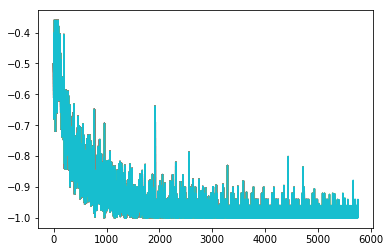

In [192]:
for i in range(30):
    losses.extend(train(model, train_data))
    plt.plot(losses)
    print(test(model, test_data))